<center><h1>Data Engineering</h1></center>

<h2>Overview</h2>

<ul>
<li>The Machine Learning Process</li>
<li>Connecting Spark with Postgres</li>
    <li>Data Cleaning</li>      
    <li>Feature Engineering<ul><li>Variable Types</li><li>Summary Statistics</li><li>Five-number Summary and Boxplots</li>
    <li>Numeric Variables<ul>
        <li>Identifying High Correlations</li>
        <li>Handling Outliers</li>
        </ul>
    </li>
    <li>Categorical Variables and Categories' Encoding</li>
    <li>Assembling Features into One Vector</li>
    <li>Data Scaling</li>
    <li>Data Pipelines</li>
    </ul></li></ul>
    </ul>

<h1>The Machine Learning Process</h1>

Let's look at a real-life example of machine learning. Imagine you run a website where people sell their cars. You want your system to suggest fair starting prices for sellers when they post ads. Regression analysis can help in this case by using data from past sales, looking at car features and prices, and finding patterns between them. However, your database doesn't have enough ads, so you decide to gather car prices from public sources. You find many useful car sale records online, but much of the data is in CSV files, and a lot of it is in PDF and Word documents (with car sale listings).

First, you go through the PDFs and Word documents to find and match similar details, like manufacturer, model, and make. Since a regression model can't work with text values (like 'automatic' or 'manual'), you create a method to turn these values into numbers. Then, you realize that some important details, like the year the car was made, are missing from certain records, so you choose to remove those incomplete records from your dataset.

Once you've cleaned and stored the data, you begin to explore different aspects of it—like how the fields relate to each other and their patterns (this helps reveal underlying connections within the data). Next, you choose the right type of regression analysis to apply

Suppose you pick linear regression because the relationships in the data seem to be linear based on your earlier analysis. Before creating the model, you normalize and scale the data (I'll explain how and why this is important later) and divide it into training and validation sets. You then train your model using the training data, using past data to adjust the model's settings to predict future prices that are unknown. After training, you end up with a functional linear regression model.

However, when you test the model on your validation dataset, the performance is disappointing. You adjust some of the training parameters, test the model again, and continue this cycle until the model performs satisfactorily. Once it's working well, you integrate the model into your web application. Soon after, you start receiving emails from clients curious about how you achieved this or from those unhappy with inaccurate predictions.

What this example illustrates is that a machine-learning project consists of multiple steps. Although typical steps are shown in the following figure:

<center><figure><img src="http://stat.cmu.edu/~mfarag/652/lectures/l16/machine_learning_model.png"/><figcaption>Machine Learning Modeling</figcaption></figure></center>

The entire process can usually be broken down into the following:

<b>Collecting data:</b> First the data needs to be gathered from various sources. The sources can be log files, database records, signals coming from sensors, and so on. Spark can help load the data from relational databases, CSV files, remote services, and distributed file systems like HDFS, or from real-time sources using Spark Streaming.

<b>Cleaning and preparing data:</b> Data isn’t always available in a structured format appropriate for machine learning (text, images, sounds, binary data, and so forth), so you need to devise and carry out a method of transforming this unstructured data into numerical features. Additionally, you need to handle missing data and the different forms in which the same values can be entered (for example, VW and Volkswagen are the same carmaker). Often, data also needs to be scaled so that all dimensions are of comparable ranges.

<b>Analyzing data and extracting features:</b> Next you analyze the data, examine its correlations, and visualize them (using various tools) if necessary. (The number of dimensions may be reduced in this step if some of them don’t bring any extra information: for example, if they’re redundant.) You then choose the appropriate machine-learning algorithm (or set of algorithms) and split the data into training and validation subsets—this is important because you’d like to see how the model behaves on the data not seen during the training phase. Or you decide on a different cross-validation method, where you continuously split the dataset into different training and validation datasets and average the results over the rounds.

<b>Training the model:</b> You train a model by running an algorithm that learns a set of algorithm-specific parameters from the input data.

<b>Evaluating the model:</b> You then put the model to use on the validation dataset and evaluate its performance according to some criteria. At this point, you may decide that you need more input data or that you need to change the way features were extracted. You may also change the feature space or switch to a different model. In any of these cases, you go back to step 1 or step 2.

<b>Using the model:</b> Finally, you deploy the built model to the production environment of your website.

The mechanics of using an API (Spark or some other machine-learning library) to train and test the models is only the last and the shortest part of the process. Equally important are collection, preparation, and analysis of data, where knowledge about the problem domain is needed.

<h1>Process Flow for Big-Data Machine Learning Process</h1>

<center><figure><img src="http://stat.cmu.edu/~mfarag/14810/l15/machine_learning_modeling_lifecycle_in_big_data.png"/><figcaption>Process Flow for Big-Data Machine Learning Modeling</figcaption></figure></center>

<h3>Food for Thought: Why do you think a 2-phase process is necessary in big-data ML modeling?!</h3>

<h1>Phase-I Ingest Data from CSV and Insert them into PostgreSQL</h1>

<h2>1. Data Ingestion</h2>

In [1]:
!python -m wget https://www.andrew.cmu.edu/user/mfarag/14763/KDDTrain+.txt

/home/reid/anaconda3/bin/python: No module named wget


<h2>Initialize the Application</h2>

In [2]:
# Uncomment the following lines if you are using Windows!
import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Big Data Analytics"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

24/09/18 15:36:16 WARN Utils: Your hostname, omen-20 resolves to a loopback address: 127.0.1.1; using 192.168.1.156 instead (on interface wlo1)
24/09/18 15:36:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/18 15:36:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/reid/anaconda3/lib/python3.12/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<h2>Read-in the Dataset</h2>

In [4]:
# Load data from csv to a dataframe on a local machine. 
# header=False means the first row is not a header 
# sep=',' means the column are seperated using ','
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","classes","difficulty_level"]

df = spark.read.csv("KDDTrain+.txt",header=False, inferSchema= True).toDF(*col_names)

<h3>For this lecture's purposes, We will insert the data into the table using the overwrite mode</h3>
If the overwrite mode is not working for you, please populate the table by creating the SQL table and using the append mode to populate it.

In [5]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="bigdata"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "NSLKDD"


df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()


24/09/18 15:37:04 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


<h2>Now, read the data back!</h2>

In [15]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(1, vertical=True)
df_read.printSchema()

-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 src_bytes                   | 491      
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count      

<h2>2. Now, let's go ahead and talk about Data Cleaning and Preprocessing.</h2>

It's important to clean your data before storing them in the database tables. In some cases, it's OK to conduct data cleaning before before you conduct feature engineering. In Data cleaning, we typically need to conduct the following activities:
<ul>
<li>Rename the column names to remove special characters and blanks - if any - with an underscore “_”;</li>
    <li>Choose the correct data type for your columns and cast column data types as needed</li>
<li>Drop the columns that are not of interest to you (duplicated, not included in research, etc.)</li>
<li>Handle missing values and N/As</li>
    </ul>

<h3>2.1 Let's test renaming columns, casting column data types and dropping duplicate rows</h3>
You may use these techniques in other activities (e.g., project or HW assignments)

In [13]:
# Column Rename
renamed_columns_df = df_read.withColumnRenamed("rerror_rate","newly_renamed_rerror_rate")
# Casting one column type
casted_types_df = (renamed_columns_df.withColumn("new_column_srv_serror_rate", \
                    renamed_columns_df["srv_serror_rate"] \
                    .cast("integer")).drop("srv_serror_rate")
                    .distinct() # deleting duplicate rows
           )
casted_types_df = casted_types_df.withColumnRenamed("new_column_srv_serror_rate","srv_serror_rate")

In [14]:
casted_types_df.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

## Please note that these column renames are for experimental purposes only to show you how to use these functions. However, this dataset doesn't need these column renames. So, we will go back to use our df_read object.

In [16]:
# We are assigning the df_read to casted_types_df because no data type changes were needed
casted_types_df = df_read

In [17]:
casted_types_df.show(1,vertical=True)

-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 src_bytes                   | 491      
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count      

<h3>2.2.1 Types of Missing Values</h3>

There are several ways to handle missing values in your dataset. You need to stay vigilent in selectin the approach since some of these methods may impact the quality of your data.

<ul>
    <li>Missing Completely at Random (MCAR): The probability of missing values is the same across all the variables.</li>
<li>Missing at Random (MAR): Like MCAR but it is possible to predict the missing value based on some other variables.</li>
<li>Not Missing at Random (NMAR): This can be handled by studying the root cause of missing</li>
</ul>


<h3>2.2.2 Reasons for Missing Values</h3>


<ul>
    <li>Data may be missing for some of the time period of the analysis.</li>
<li>Events not happening, such as a student's exam score missing because they didn't take the test.</li>
<li>Responses omitted for certain survey questions.</li>
<li>Questions not applicable in some contexts.</li>
    <li>Random gaps in data.</li>
</ul>


<h3>2.2.3 Handling Missing Values</h3>

There are several ways to handle missing values in your dataset. You need to stay vigilent in selectin the approach since some of these methods may impact the quality of your data.

<ul>
    <li><b>Drop Columns:</b> Removing a column from your dataset is always possible, but you should carefully consider whether to clean it using a different method or to remove it entirely. Your decision should be guided by several factors, such as the importance of the data in the column and the proportion of missing values. As a general guideline, avoid dropping a column if it contains meaningful data in at least 50% of its entries.</li>
    <li><b>Drop Rows having Nulls:</b> This is always an option as well. However, depending on the size of your dataset and the number of rows to be dropped, this "may/may not" be a good option. For rows, you can use a similar threshold (50%) and drop rows with missing values only if it doesn't significantly reduce your sample size</li>
    <li><b>Fill the missing values:</b> This approach is "usually" applicable for numeric columns. This is done using an operation that is called <b>imputation</b>. By creating imputed columns, we will create columns which will consist of values that fill the missing value by taking a statistical method such as mean/median of the original columns to fill the missing value.
</li>
</ul>


<h3>2.2.3.1 Check NA Values</h3>

<h3>In some cases, your dataframe is able to detect if your cells/fields are empty or holding a missing value. In this case, missing values can be spotted using isNull or is NaN</h3>

In [18]:
from pyspark.sql.functions import *

null_counts_plays_df = df_read.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df_read.columns])

null_counts_plays_df.show(truncate=False, vertical=True)

-RECORD 0--------------------------
 duration                    | 0   
 protocol_type               | 0   
 service                     | 0   
 flag                        | 0   
 src_bytes                   | 0   
 dst_bytes                   | 0   
 land                        | 0   
 wrong_fragment              | 0   
 urgent                      | 0   
 hot                         | 0   
 num_failed_logins           | 0   
 logged_in                   | 0   
 num_compromised             | 0   
 root_shell                  | 0   
 su_attempted                | 0   
 num_root                    | 0   
 num_file_creations          | 0   
 num_shells                  | 0   
 num_access_files            | 0   
 num_outbound_cmds           | 0   
 is_host_login               | 0   
 is_guest_login              | 0   
 count                       | 0   
 srv_count                   | 0   
 serror_rate                 | 0   
 srv_serror_rate             | 0   
 rerror_rate                

So, our NSL-KDD dataset is clean but let's assume some hypothetical scenarios here.

<h3>2.2.3.2 Let's play with some null value handling. To drop all rows with null value(s):</h3>

In [19]:
casted_types_df_with_na_dropped_rows = casted_types_df.na.drop()
casted_types_df_with_na_dropped_rows.show(1,vertical=True)

-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 src_bytes                   | 491      
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count      

<h3>2.2.3.3 To drop rows based on number of NAs in the row:</h3>

In [20]:
casted_types_df_with_na_dropped_rows = casted_types_df.na.drop(how="any", thresh=2)
casted_types_df_with_na_dropped_rows.count()

125973

<h3>2.2.3.4 What if the number of missing values is large or we don't want to drop them due to a potential significant impact to our sample size? Imputation can be an option. Let's go ahead and assume we have null values in <b>src_bytes</b> column and we would like to <b>impute</b> them.</h3> 

In [13]:
#In some cases, your missing values are recoded with a string value (and not recognized in Spark as Null explicitly)
# The below code can be partially used outside of imputation context 
# to replace a string value with NA using regex_replace
missing_value = "NA"
df_with_substituted_na = (casted_types_df_with_na_dropped_rows\
    .withColumn('src_bytes', \
                when(casted_types_df_with_na_dropped_rows.src_bytes==missing_value,\
                    regexp_replace(casted_types_df_with_na_dropped_rows.src_bytes,missing_value,None)) \
                .otherwise(casted_types_df_with_na_dropped_rows.src_bytes))\
                )

df_with_substituted_na.show(1, vertical=True)


-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 src_bytes                   | 491      
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count      

In [14]:
from pyspark.ml.feature import Imputer

columns_to_be_imputed = ["src_bytes"]
value_not_in_dataset = -200

# Replace None/Missing Value with a value that can't be present in the dataset.
df_with_filled_na = casted_types_df_with_na_dropped_rows.fillna(-200, columns_to_be_imputed)

#Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_with_filled_na).transform(df_with_filled_na)
# we will drop the old column without imputation. We have only one column to be imputed
df_imputed_enhanced = df_imputed.drop(columns_to_be_imputed[0])

# We will rename our newly imputed column with the correct name
df_fully_imputed = df_imputed_enhanced.withColumnRenamed("src_bytes_imputed","src_bytes")

In [15]:
df_fully_imputed.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- srv_count: integer (nullable = true

In [16]:
df_fully_imputed.show(1,vertical=True)

-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count                   | 2        
 serror_rate    

<h1>Phase-II: ML Modeling and MLOps </h1>

<h2>Now, let's go ahead and talk about Feature Engineering.</h2>

The basic process here is:<ul>
<li>Begin by classifying your variables into numerical and categorical</li>

<li>Then, look at  numerical summaries of numerical variables.</li>

<li>Follow this with an examination to the distribution of each variable individually.</li>

<li>Then move on to study the relationships among the variables.</li>

<li>Try to visualize all what you can!</li>

</ul>

Exploring data for machine learning is a lot similar to exploring data when performing a transformation in the sense that we manipulate the data to uncover some inconsistencies, patterns, or gaps

<h2>1. Classify Your variables</h2>

<ul>
<li>The information is organized in variables.</li>
<li>A variable is any characteristic of an individual or a case.</li>
    <li>In Spark, each attribute (column) in your dataframe represent a variable</li>    
    <li>A variable can take different values for different individuals.</li>
</ul>

<h3>Reminder: Types of Variables</h3>

<ul>
    <li><b>Continuous Variables: or quantitative variables.</b></li>
    <li><b>Categorical Variables:</b> can be divided into:
        <ul>
            <li><b>Binary Variables:</b> when you have only two choices (0/1, True/False)</li>            
            <li><b>Ordinal Variables:</b> when the categories have a certain ordering (like low/medium/high)</li>
            <li><b>Nominal Variables:</b> when the categories have no specific ordering (like the color of an item).</li>
        </ul>
    </li>
</ul>

Note the following:
    <ul>
    <li>Identifying your variables as categorical (with the proper sub-type) or continuous has a direct impact on the data preparation and, down the road, the performance of your machine learning model.</li>
    <li>Proper identification is dependent on the context (what does the column mean?) and how you want to encode its meaning.</li>
    <li>Don’t worry if you don’t get it right the first time. You can always come back and touch up your feature types.</li>
    </ul>

<center><figure><img src="http://stat.cmu.edu/~mfarag/14810/l12/feature_types.png"/><figcaption>Image taken from https://livebook.manning.com/#!/book/data-analysis-with-python-and-pyspark/discussion</figcaption></figure></center>

<h2>2. Creating a Summary Table</h2>

<ul>
<li>Checking the summary statistics for our dataframe helps us validate our numerical columns. This is helpful for several reasons such as understanding the variability in your data and the scale of data for each variable.</li>
    <li>Remember, your ML model is mathematical model after all. If you have variable that includes values between 0 and 100, it will have higher influence than a column that has values between 0 and 1.</li>
    <li>You may include the Summary columns for some categorical columns but you would have to ignore them during your analysis</li></ul>

In [17]:
df_fully_imputed.summary().show(truncate=False, vertical=True)

-RECORD 0--------------------------------------------
 summary                     | count                 
 duration                    | 125973                
 protocol_type               | 125973                
 service                     | 125973                
 flag                        | 125973                
 dst_bytes                   | 125973                
 land                        | 125973                
 wrong_fragment              | 125973                
 urgent                      | 125973                
 hot                         | 125973                
 num_failed_logins           | 125973                
 logged_in                   | 125973                
 num_compromised             | 125973                
 root_shell                  | 125973                
 su_attempted                | 125973                
 num_root                    | 125973                
 num_file_creations          | 125973                
 num_shells                 

Wouldn't it be better to use graphs to look at these numbers rather than looking at it yourself?

<h3>The five-number summary</h3>

The five-number summary of a set of observations consists of the smallest observation, the first quartile, the median, the third quartile, and the largest observation, written in order from smallest to largest.
In symbols, the five-number summary is
<ul>
<li>Minimum </li>
<li>25% of your data (Q1)</li>
<li>Median of your data </li>
<li>75% of your data (Q3)</li>
<li>Maximum</li>
</ul>

These five numbers give a reasonably complete description of both the center and the spread of the distribution.

<h3>Boxplots</h3>

<center><figure><img src="http://stat.cmu.edu/~mfarag/14810/l12/boxplot.png"/><figcaption>Boxplot Structure</figcaption></figure></center>

A boxplot is a graph of the five-number summary. 
<ul>
    <li>A central box spans the quartiles 𝑄1 and 𝑄3.</li>
<li>A line in the box marks the median M.</li>
<li>Lines extend from the box out to the smallest and largest observations</li>
</ul>

Boxplots are
<ul>
<li>Good for comparing data sets by showing them side-by-side on the same graph.</li>
<li>Good at showing amount of variability.</li>
<li>Weak at showing the shape of the distribution (e.g. does not show how many modes there are).</li>
    <li>Location of median indicates symmetry or asymmetry.</li>
</ul>

<b>Now, let's Draw Boxplots!!</b>

In [18]:
# We will draw boxplots for the numerical features
# Now let's check the datatypes of the dataframe
df_fully_imputed.dtypes

[('duration', 'int'),
 ('protocol_type', 'string'),
 ('service', 'string'),
 ('flag', 'string'),
 ('dst_bytes', 'int'),
 ('land', 'int'),
 ('wrong_fragment', 'int'),
 ('urgent', 'int'),
 ('hot', 'int'),
 ('num_failed_logins', 'int'),
 ('logged_in', 'int'),
 ('num_compromised', 'int'),
 ('root_shell', 'int'),
 ('su_attempted', 'int'),
 ('num_root', 'int'),
 ('num_file_creations', 'int'),
 ('num_shells', 'int'),
 ('num_access_files', 'int'),
 ('num_outbound_cmds', 'int'),
 ('is_host_login', 'int'),
 ('is_guest_login', 'int'),
 ('count', 'int'),
 ('srv_count', 'int'),
 ('serror_rate', 'double'),
 ('srv_serror_rate', 'double'),
 ('rerror_rate', 'double'),
 ('srv_rerror_rate', 'double'),
 ('same_srv_rate', 'double'),
 ('diff_srv_rate', 'double'),
 ('srv_diff_host_rate', 'double'),
 ('dst_host_count', 'int'),
 ('dst_host_srv_count', 'int'),
 ('dst_host_same_srv_rate', 'double'),
 ('dst_host_diff_srv_rate', 'double'),
 ('dst_host_same_src_port_rate', 'double'),
 ('dst_host_srv_diff_host_rate'

In [19]:
numeric_features = [feature[0] for feature in df_fully_imputed.dtypes if feature[1] in ('int','double')]
numeric_features

['duration',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'difficulty_level',
 'src_bytes']

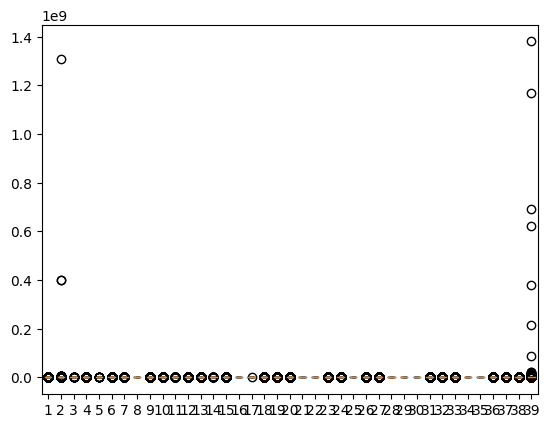

In [20]:
import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
converted_data = df_fully_imputed[numeric_features].toPandas()

figure = plt.boxplot(converted_data)

That looks ugly!!! Let's get a subset of the variables and display them.

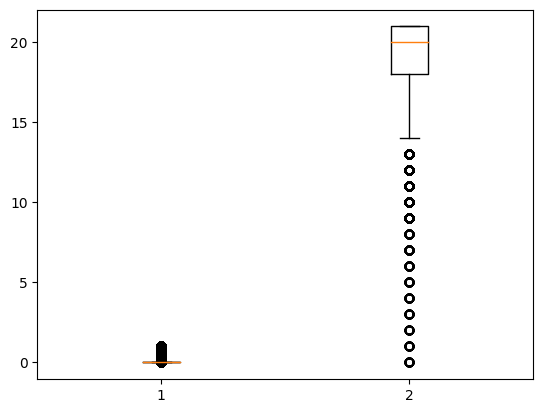

In [21]:

spotted_data = df_fully_imputed[numeric_features[36:38]].toPandas()
figure_subset = plt.boxplot(spotted_data)

Did you think what the circles in the previous graph represent?

The answer is <b>Outliers</b>.

Based on these results, we MAY need to <b>handle outliers</b>!!

<h2>3. Outliers</h2>

An outlier is an observation that is usually large or small relative to the other values in a data set. Identifying outliers is crucial for the selection of the ML model. Some models are more sensitive to outliers than others.

Outliers are typically attributable to one of the following causes:
<ul><li>The observation is observed, recorded, or entered incorrectly.</li>
<li>The observation comes from a different population.</li>
<li>The observation is correct but represents a rare event</li>
    </ul>

<h3>How to spot an Outlier in Numerical Variable?</h3>

There are several ways to find outliers. The most important way is the Inter-Quartile Range (IQR). The IQR is a measure of spread that is less sensitive to the influence of extreme values.<br/> The IQR is defined as Q3 - Q1 from your boxplot.

<h3>How does the IQR is used in spotting Outliers?</h3>

The rule of <b>1.5×IQR Criterion for outliers</b>. Call an observation a suspected outlier if it falls:
<ul>
    <li>more than 1.5×IQR above the 3rd quartile or</li>
    <li>more than 1.5×IQR below the 1st quartile</li>
</ul>

<center><figure><img src="http://stat.cmu.edu/~mfarag/14810/l13/iqr_for_outliers.png"/></figure></center>

In [22]:
figure_subset.keys()

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])

<h3>How to Print Q1 and Q3 Ranges?</h3>

In [23]:
# Values printed as comma separated Q1, Q3 for each object.
[item.get_ydata()[1] for item in figure_subset['whiskers']]

[0.0, 0.0, 14.0, 21.0]

<h3>How to Print the Outliers?</h3>

In [24]:
# how to print outliers?!
[item.get_ydata() for item in figure_subset['fliers']]

[array([0.01, 1.  , 1.  , ..., 0.02, 0.93, 1.  ]),
 array([12., 11.,  2., ..., 10., 12., 11.])]

<h3>Look through the following code and understand the find_outliers() function</h3>

In [25]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [26]:
# As a reminder, we don't have any null values for the outliers to be handled
numeric_columns = [column[0] for column in df_fully_imputed.dtypes if column[1] in ('int','double')]
df_fully_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_columns]).show(1, vertical=True)


-RECORD 0--------------------------
 duration                    | 0   
 dst_bytes                   | 0   
 land                        | 0   
 wrong_fragment              | 0   
 urgent                      | 0   
 hot                         | 0   
 num_failed_logins           | 0   
 logged_in                   | 0   
 num_compromised             | 0   
 root_shell                  | 0   
 su_attempted                | 0   
 num_root                    | 0   
 num_file_creations          | 0   
 num_shells                  | 0   
 num_access_files            | 0   
 num_outbound_cmds           | 0   
 is_host_login               | 0   
 is_guest_login              | 0   
 count                       | 0   
 srv_count                   | 0   
 serror_rate                 | 0   
 srv_serror_rate             | 0   
 rerror_rate                 | 0   
 srv_rerror_rate             | 0   
 same_srv_rate               | 0   
 diff_srv_rate               | 0   
 srv_diff_host_rate         

In [27]:
df_with_outlier_handling = find_outliers(df_fully_imputed)
df_with_outlier_handling.show(1, vertical=True)

-RECORD 0-------------------------------
 duration                    | 0        
 protocol_type               | tcp      
 service                     | ftp_data 
 flag                        | SF       
 dst_bytes                   | 0        
 land                        | 0        
 wrong_fragment              | 0        
 urgent                      | 0        
 hot                         | 0        
 num_failed_logins           | 0        
 logged_in                   | 0        
 num_compromised             | 0        
 root_shell                  | 0        
 su_attempted                | 0        
 num_root                    | 0        
 num_file_creations          | 0        
 num_shells                  | 0        
 num_access_files            | 0        
 num_outbound_cmds           | 0        
 is_host_login               | 0        
 is_guest_login              | 0        
 count                       | 2        
 srv_count                   | 2        
 serror_rate    

In [28]:
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             1|41051|
|             6|  247|
|             3| 2637|
|             5| 1342|
|             9|    9|
|             4|  452|
|             8|   55|
|             7|   39|
|            10|    4|
|            11|    1|
|             2| 6915|
|             0|73221|
+--------------+-----+



We don't want to lose lots of records for outliers. We will drop the rows with more than 4 outliers. 

In [29]:
df_with_substituted_na_and_outliers = df_with_outlier_handling.\
        filter(df_with_outlier_handling['total_Outliers']<=4)
print(df_with_substituted_na_and_outliers.count())

124276


<h2>4. Variable Distribution</h2>

<ul>
<li>The distribution of a variable tells us what values it takes and how often it takes these
values.</li>
    <li>In any graph of data, look for the overall pattern and for striking deviations from that
pattern.</li>
    <li>Overall pattern of a distribution can be described by its shape centre and spread</li>
    <li>An important kind of deviation is <b>an outlier</b> an individual value that falls outside the
overall pattern.</li>
</ul>

Try to answer the following questions when looking at the distribution.
<ul>
<li>Does the distribution have one or several major peaks, usually called modes A
    distribution with one major peak is called unimodal</li>
    <li>Is it approximately symmetric or skewed in one direction?</li>
</ul>

We can use <b>Seaborn</b> to visualize the variable distribution along with its <b>correlation</b> with other variables.

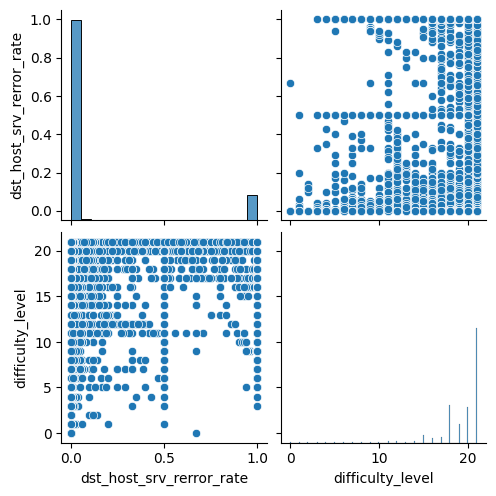

In [30]:
import seaborn as sb

sb.pairplot(spotted_data)

<ul>
    <li>Distributions show visual correlation of variables and we identified two possible columns to be dropped. Let's take a look at the correlation between all the variables and find the variables with strong correlation.</li>
    <li><b>Strong correlation</b> is identified with <b>>= 0.8 correlation coefficient.</b> </li>
    <li><b>In order for correlation to work, null values should be handled. </b></li>
    </ul>

<h2>5. Correlations</h2>

Correlation means a mutual relationship between two or more things. Consider data points (xᵢ , yᵢ), i = 1,2,…n in a dataset. <b>The objective of correlation</b> is to see if large values of “x” are paired with large values of “y” and small values of “x” are paired with small values of “y”. If not, check if small values of “x” are paired with large values of “y” and vice versa.



In general, it is recommended to avoid having correlated features in your dataset. Indeed, a group of highly correlated features will not bring additional information (or just very few), but will increase the complexity of the algorithm, thus increasing the risk of errors. Depending on the features and the model, correlated features might not always harm the performance of the model but that is a real risk.

<h3>Why would you drop highly correlated features?</h3>

In feature engineering, we remove highly correlated features for <b>storage and speed concerns.</b>

<h3>Now that we handled null values, we can calculate the correlation using the <b>corr()</b> function in Pandas dataframe. PySpark has built-in correlation support as well using the Correlation class. However, it doesn't print the values as nicely as corr() function. So, for academic purposes, we will use the corr() function.</h3>

In [ ]:
correlation_matrix = df_with_substituted_na_and_outliers.toPandas().corr()
print(correlation_matrix)

In the previous results, look for strong correlations among variables. Notice the following:
<ul>Strong Correlations among:
    <li>serror_rate</li>
    <li>dst_host_serror_rate</li>
    <li>srv_serror_rate</li>
    <li>dst_host_srv_serror_rate</li>
</ul>

Strong Correlations among:
<ul>
    <li>rerror_rate</li>
    <li>srv_rerror_rate</li>
    <li>dst_host_rerror_rate</li>
    <li>dst_host_srv_rerror_rate</li>
</ul>

<h3>So, we should keep one variable from each group</h3>

In [ ]:
df_with_handled_correlations = df_with_substituted_na_and_outliers\
                .drop("dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate")

At this point, you should have handled continuous variables. <b>Next, let's look at categorical variables: Binary, Nominal and Ordinal variables</b>

<h2>6. Handle Binary Variables (by casting them)</h2>

If you have boolean variables (i.e. True/False variables), you should convert them to 0's and 1's. 
<ul>
    <li>0 belongs to False and 1 reflects True values.</li> 
    <li>In this dataset,there are no False and True values. They are already converted to 0's and 1's (e.g. is_guest_login variable)</li>
    <li>However, you will have the opportunity to cast binary variables in the homework.</li>
</ul>

<h3>Here is an example on how to handle binary variables</h3>

In [ ]:
df_with_handled_binary = (df_with_handled_correlations
              .withColumn("is_guest_login_encoded", \
                          df_with_handled_correlations["is_guest_login"].cast("integer")))
df_with_handled_binary.select("is_guest_login","is_guest_login_encoded").distinct().show()

## Again, we don't need to handle binary variables in this example and therefore, we don't need is_guest_login_encoded column. So, I'll assign the df_with_handled_binary to its old value. You don't need this step in the HW.

In [ ]:
# You don't need this if you are handling binary variables
df_with_handled_binary = df_with_handled_correlations

<h2>7. Handling Ordinal and Nominal Variables</h2>

Many machine learning algorithms cannot work with categorical data directly. The categories must be converted into numbers. This is required for both input and output variables that are categorical.

Converting strings to numbers can be achieved using one of the following <b>options:</b>
<ul>
    <li>StringIndexer from pyspark.ml.feature. This option assigns a number to each level.  This may work for problems where there is a natural ordinal relationship between the categories, and in turn the integer values, such as labels for temperature 'cold', 'warm', and 'hot'. In StringIndexers, the most frequent value would get index 0, followed by the next most frequent and so on. However, there may be problems when there is no ordinal relationship and allowing the representation to lean on any such relationship might be damaging to learning to solve the problem. An example might be the labels 'dog' and 'cat'.<br/>

In these cases, we would like to give the network more expressive power to learn a probability-like number for each possible label value. This can help in both making the problem easier for the network to model. When a one hot encoding is used for the output variable, it may offer a more nuanced set of predictions than a single label.
</li>  
    </ul>

<ul>
    <li>OneHotEncoder (for Spark >= 3.0) or OneHotEncoderEstimator (for Spark >= 2.3) from pyspark.ml.feature library. A one hot encoding allows the representation of categorical data to be more expressive. This option will create dummy variables for each category, thereby increasing the number of features we work with. In our selected dataset, the special teams play type and offensive information variables need to be encoded.</li>
   </ul>

<h3>String Indexer vs. One-Hot Encoder</h3>

String Indexing assigns a unique integer value to each category. 0 is assigned to the most frequent category, 1 to the next most frequent value, and so on. We have to define the input column name that we want to index and the output column name in which we want the results.

However, <b>String Indexers impose an order or rank on your data and therefore, they only fit ordinal variables.</b> To represent <b>nominal variables,</b> we should use <b>One-Hot encoders.</b> In Spark, encoding is done as series of tasks that are executed via <b>pipelines</b>.

<h1>Data Processing Pipelines</h1>

It's popular to use several machine learning models together. Therefore, machine learning workflows could get complex and hard to maintain. Data processing pipelines can help reducing the complexity of the machine learning workflow by allowing the reuse of workflow components across several models. A pipeline is a linear sequence of data processing and transformation stages, where each stage can be either a data transformer (for data preparation and feature engineering) or a machine learning estimator (for model training). Pipelines are designed to make it easier to construct, evaluate, and deploy machine learning workflows. 

<h2>Pipeline Components</h2>

The main pipeline components are:
    <ul>
    <li>Transformers</li>
    <li>Estimators</li>
    </ul>

<h2>Transformers</h2>

<b>Transformers</b> typically refer to components or stages in a machine learning pipeline that are used to transform and preprocess data. These transformers are part of the Spark ML library and they are used to perform various operations on data. These operations include feature extraction, transformation, and scaling, before feeding it into machine learning algorithms. 
Technically, a Transformer implements a method transform(), which converts one DataFrame into another, generally by appending one or more columns.<br/>

Examples of built-in transformers include: Tokenizer, StandardScaler, VectorAssembler, OneHotEncoder, and StringIndexer.

We can also create custom Transformers by subclassing the `Transformer` class (in `pyspark.ml`). The basic syntax for creating a transformer is


In [ ]:
from pyspark.ml import Transformer

class myCustomTransformer(Transformer):
    def __init__(self):
        super().__init__()
    
    def _transform(self, input_df):
        # do some processing steps here
        return output_df
    
transformer1 =  myCustomTransformer()
transformer2 =  myCustomTransformer()

In [ ]:
from pyspark.ml import Pipeline
# You can use different types of transformers, estimatorabss as well.
mypipeline = Pipeline(stages=[transformer1, transformer2])

<h2>Estimators</h2>

An estimator is an algorithm or model-building tool that takes a dataset and returns a model. In other words, it's an abstraction of a learning algorithm.

Examples of built-in estimators include
<ul>
    <li>LogisticRegression: An estimator used for binary classification.</li>
<li>RandomForestClassifier: An estimator for classification tasks using random forests.</li>
<li>LinearRegression: An estimator for linear regression tasks.</li>
<li>KMeans: An estimator for clustering using the K-means algorithm.</li>
    </ul>

<h3>Estimator Components</h3>

Estimators typically have two main methods: fit and transform.
<ul>
    <li>The <b>fit</b> method is used to train the estimator on a given dataset. It takes a DataFrame as input and returns a model.</li>
    <li>The <b>transform</b> method is used to apply the trained model to new data, transforming the input data into predictions or other outputs.</li>
    </ul>

<h3>Let's take an example where we try to one-hot encode activity classes in our NSL-KDD dataset</h3>

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


# We don't have any ordinal variables. Only nominal variables
# first part : transform the columns to numeric
stage_1 = StringIndexer(inputCol= 'classes', outputCol= 'classes_index')
stage_2 = StringIndexer(inputCol= 'protocol_type', outputCol= 'protocol_type_index')
stage_3 = StringIndexer(inputCol= 'service', outputCol= 'service_index')
stage_4 = StringIndexer(inputCol= 'flag', outputCol= 'flag_index')

# second part : one-hot encode the numeric columns
stage_5= OneHotEncoder(inputCols=["classes_index","protocol_type_index",
                                  "service_index","flag_index"], 
                        outputCols=['classes_encoded','protocol_type_encoded',
                                   'service_encoded','flag_encoded'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(df_with_handled_binary)
df_encoded = pipeline_model.transform(df_with_handled_binary)


<h3>In order to view/read the output of One-Hot encoding, it's best to convert your mini-dataframe to Pandas</h3>

In [ ]:
# Notice, the length of our One-Hot Encoding array
print(df_encoded.select("classes").distinct().count())
# In our NSL-KDD dataset, the length is 3. Now, let's view some examples
df_encoded.select("classes","classes_index","classes_encoded")\
                .distinct().toPandas()


Read more about One-Hot Encoding and String Indexing from this article: <a href="https://medium.com/@nutanbhogendrasharma/role-of-onehotencoder-and-pipelines-in-pyspark-ml-feature-part-2-3275767e74f0">https://medium.com/@nutanbhogendrasharma/role-of-onehotencoder-and-pipelines-in-pyspark-ml-feature-part-2-3275767e74f0</a>

<h2>8. Combining Features into Single Vector</h2>

Typically, machine learning models accept the ML input as a vector of features. So, to combine your features into a single vector in Spark, you may use VectorAssembler.

In [ ]:
feature_list = df_encoded.drop("classes","classes_index",
                                        "protocol_type","protocol_type_index",
                                        "service","service_index",
                                        "flag","flag_index").columns
print(feature_list)

In [ ]:
from pyspark.ml.feature import VectorAssembler


vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_encoded)

In [ ]:
df_with_assembled_features.select("vectorized_features").show(1, truncate=False)

<h3>Important Note: Your Machine Learning Target/Outcome Variable MUST NOT be in the Feature List that is Assembled</h3>

In [ ]:
# Let's take an example if we are trying to predict the activity/attack classes. 
# In this case, classes should not be in the feature list.
# Notice we are dropping classes_encoded variable here
feature_list = df_encoded.drop("classes","classes_index",
                                        "protocol_type","protocol_type_index",
                                        "service","service_index",
                                        "flag","flag_index",
                              "classes_encoded").columns

vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_encoded)

In [ ]:
df_with_assembled_features.select("vectorized_features","classes_encoded","classes")\
    .distinct().toPandas()

Now that we are done with assembling all the features, <b>let's scale them so they all have standard domains and no feature will have significantly higher impact than another one before we develop our machine learning model.</b>

<h2>9. Data Scaling</h2>

In most cases, the numerical features of the dataset do not have a certain range and they differ from each other. In order for a symmetric dataset, scaling is required.

<h4>Normalization</h4>
Normalization (or min-max normalization) scales all values in a fixed range between 0 and 1. This transformation does not change the distribution of the feature and due to the decreased standard deviations, the effects of the outliers increases. Therefore, before normalization, it is recommended to handle the outliers
<h4>Standardization</h4>
Standardization (or z-score normalization) scales the values while taking into account standard deviation. If the standard deviation of features is different, their range also would differ from each other. This reduces the effect of the outliers in the features.

<center><figure><img width="300" height="120" src="http://stat.cmu.edu/~mfarag/652/lectures/l22/scaling.png"/><figcaption>Scaling Formulas</figcaption></figure></center>

In this class, we will focus on standard scalers. StandardScalers standardize features by removing the mean and scaling to unit variance using column summary statistics on the samples in the training set.

The “unit std” is computed using the corrected sample standard deviation, which is computed as the square root of the unbiased sample variance.



<h3>To scale data to predict Activity/Attack Classes</h3>
The code is shown below.

In [ ]:
from pyspark.ml.feature import StandardScaler
standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select("classes","classes_encoded","features").distinct().toPandas()

<h3>And at this point, your data should be ready for your ML model.</h3>

<h2>Summary of Data Engineering</h2>

 <ul>
    <li>1. Data Ingestion</li>
    <li>2. Data Cleaning. This includes handling missing values (via dropping or imputation), renaming columns and casting column data types.</li>
    <li>3. Variable Classification</li>
        <li>4. For continuous variables, 
            <ul>
                <li>use boxplots to identify if outliers exist and handle outliers.</li>
                <li>use variable distributions and handle high correlations</li>
            </ul>
        <li>5. For Binary variables, cast them from boolean to integer data types - if needed-</li>
        <li>6. For ordinal variables, encode them using StringIndexers</li>
        <li>7. For nominal variables, encode them using One-Hot Encoding</li>
        <li>8. Assemble your input features as into single vector</li>
        <li>9. Scale your feature vector</li>
</ul>

<h1>Reading</h1>

<ul>
    <li>Types of Missing Values: <a href="https://stefvanbuuren.name/fimd/sec-MCAR.html">https://stefvanbuuren.name/fimd/sec-MCAR.html<a/></li>
<li>Read more about One-Hot Encoding and String Indexing from this article: <a href="https://stefvanbuuren.name/fimd/sec-MCAR.html">https://medium.com/@nutanbhogendrasharma/role-of-onehotencoder-and-pipelines-in-pyspark-ml-feature-part-2-3275767e74f0</a></li>
</ul>